# RND Experiment Framework

This notebook provides a modular framework for running Random Network Distillation (RND) experiments with different hyperparameters.

## Structure

1. **Function Definitions** (Cells 2-6):
   - `load_data()`: Load and prepare the dataset
   - `initialize_model()`: Initialize the SemanticRND model
   - `train_rnd()`: Train the model and track metrics
   - `test_rnd()`: Test the trained model
   - `analyze_and_visualize()`: Analyze results, create plots, and save to JSON
   - `run_rnd_experiment()`: Main function that runs a complete experiment

2. **Usage Examples**:
   - **Single Experiment**: Run one experiment with specific hyperparameters
   - **Hyperparameter Tuning**: Run multiple experiments with different configurations
   - **Comparison**: Compare results across all experiments

## Available Encoder Models

Use short nicknames for convenience:
- **`'gte'`** → Alibaba-NLP/gte-modernbert-base (default, good general performance)
- **`'granite'`** → ibm-granite/granite-embedding-english-r2 (IBM's large model)
- **`'granite-small'`** → ibm-granite/granite-embedding-small-english-r2 (smaller, faster)

You can also provide full model names directly.

## Quick Start

To run a single experiment, use:
```python
results = run_rnd_experiment(
    encoder_name='gte',  # or 'granite', 'granite-small'
    num_train_samples=1000,
    num_epochs=50,
    learning_rate=1e-4,
    batch_size=50,
    target_layers=(256, 128, 64),
    predictor_layers=(512, 256, 64),
    normalize_embeddings=True,
    concat_problem_answer=False
)
```

## Output Files

Each experiment generates:
- **PNG plot**: Training dynamics and results visualization (includes encoder name in filename)
- **JSON file**: Complete results including metrics and interpretations
- **Summary JSON**: Aggregated results from all experiments (when running multiple)
- **CSV comparison**: Table comparing key metrics across experiments

In [1]:
import random
import json
from pathlib import Path
from datetime import datetime
from datasets import load_dataset
from torch.cuda.amp import autocast, GradScaler
from rnd import *
import matplotlib.pyplot as plt
import numpy as np

# Model name mapping: short nicknames to full model names
ENCODER_MODELS = {
    'granite': 'ibm-granite/granite-embedding-english-r2',
    'granite-small': 'ibm-granite/granite-embedding-small-english-r2',
    'gte': 'Alibaba-NLP/gte-modernbert-base'
}

def get_encoder_name(model_key):
    """Convert short model key to full model name."""
    if model_key in ENCODER_MODELS:
        return ENCODER_MODELS[model_key]
    # If it's already a full name, return as is
    return model_key

## Encoder Model Reference

Available encoder models with short nicknames:

In [ ]:
# Print available encoder models
print("Available Encoder Models:")
print("=" * 70)
for short_name, full_name in ENCODER_MODELS.items():
    print(f"  '{short_name}' → {full_name}")
print("=" * 70)

Available Encoder Models:
  'granite' → ibm-granite/granite-embedding-english-r2
  'granite-small' → ibm-granite/granite-embedding-small-english-r2
  'gte' → Alibaba-NLP/gte-modernbert-base


In [3]:
def load_data(num_train_samples, num_test_samples, seed=42):
    """Load and prepare dataset."""
    print(f"Loading DeepMath dataset (first {num_train_samples + num_test_samples} samples)...")
    dataset = load_dataset("zwhe99/DeepMath-103K", split="train")
    dataset = dataset.shuffle(seed=seed)
    
    train_data = dataset.select(range(num_train_samples))
    test_data = dataset.select(range(num_train_samples, num_train_samples + num_test_samples))
    
    return train_data, test_data


def initialize_model(encoder_name, target_layers, predictor_layers, device, 
                     max_length, concat_problem_answer, normalize_embeddings,
                     train_data, num_train_samples):
    """Initialize SemanticRND model."""
    # Convert short name to full model name if needed
    full_encoder_name = get_encoder_name(encoder_name)
    
    print("\nInitializing SemanticRND...")
    print(f"  Encoder: {encoder_name} -> {full_encoder_name}")
    
    semantic_rnd = SemanticRND(
        encoder_model_name=full_encoder_name,
        target_layers=target_layers,
        predictor_layers=predictor_layers,
        device=device,
        max_length=max_length,
        concat_problem_answer=concat_problem_answer,
        normalize_embeddings=normalize_embeddings
    ).to(device)
    
    # Initialize embedding normalizer if enabled
    if normalize_embeddings:
        print("\nInitializing embedding normalizer with first batch...")
        init_batch = [[(train_data[i]['question'], train_data[i]['r1_solution_1']) 
                      for i in range(min(200, num_train_samples))]]
        semantic_rnd.initialize_embedding_normalizer(init_batch)
    
    print(f"✓ Model initialized on {device}")
    print(f"✓ Target network: {target_layers}")
    print(f"✓ Predictor network: {predictor_layers}")
    
    return semantic_rnd

In [9]:
def train_rnd(semantic_rnd, train_data, num_train_samples, num_epochs, 
              learning_rate, batch_size, device):
    """Train the RND model and track metrics."""
    
    optimizer = torch.optim.Adam(semantic_rnd.predictor_parameters(), lr=learning_rate)
    scaler = GradScaler()
    print("✓ Optimizer initialized.")
    
    # Prepare evaluation data once (fixed set for consistent tracking)
    print("\nPreparing evaluation data...")
    eval_size = min(100, num_train_samples)
    eval_questions = list(train_data['question'][:eval_size])
    eval_solutions_1 = list(train_data['r1_solution_1'][:eval_size])
    eval_solutions_3 = list(train_data['r1_solution_3'][:eval_size])
    eval_random_solutions = random.sample(eval_solutions_1, len(eval_solutions_1))
    
    print(f"\nTraining RND for {num_epochs} epochs on {num_train_samples} samples...")
    print(f"Processing in batches of {batch_size} samples")
    print(f"Evaluating on {eval_size} samples after each epoch\n")
    
    # Track metrics for plotting
    training_losses = []
    epoch_rewards_s1 = []
    epoch_rewards_s3 = []
    epoch_rewards_rand = []
    epoch_mse_s1 = []
    epoch_mse_s3 = []
    epoch_mse_rand = []
    epoch_ratios = []
    
    for epoch in range(num_epochs):
        # ===== TRAINING PHASE =====
        semantic_rnd.train()
        epoch_losses = []
        
        num_batches = (num_train_samples + batch_size - 1) // batch_size
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_train_samples)
            
            batch_of_groups = []
            for i in range(start_idx, end_idx):
                item = train_data[i]
                group = [
                    (item['question'], item['r1_solution_1']),
                    (item['question'], item['r1_solution_2'])
                ]
                batch_of_groups.append(group)
            
            with autocast():
                _, loss = semantic_rnd(batch_of_groups, update_stats=True)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            epoch_losses.append(loss.item())
            
            if device == 'cuda':
                torch.cuda.empty_cache()
        
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        training_losses.append(avg_epoch_loss)
        
        # ===== EVALUATION PHASE =====
        semantic_rnd.eval()
        
        eval_rewards_s1 = []
        eval_rewards_s3 = []
        eval_rewards_rand = []
        eval_mse_s1 = []
        eval_mse_s3 = []
        eval_mse_rand = []
        
        eval_batch_size = 20
        num_eval_batches = (eval_size + eval_batch_size - 1) // eval_batch_size
        
        with torch.no_grad():
            for batch_idx in range(num_eval_batches):
                start_idx = batch_idx * eval_batch_size
                end_idx = min(start_idx + eval_batch_size, eval_size)
                
                eval_batch_s1 = []
                eval_batch_s3 = []
                eval_batch_rand = []
                
                for i in range(start_idx, end_idx):
                    eval_batch_s1.append([(eval_questions[i], eval_solutions_1[i])])
                    eval_batch_s3.append([(eval_questions[i], eval_solutions_3[i])])
                    eval_batch_rand.append([(eval_questions[i], eval_random_solutions[i])])
                
                rewards_s1, mse_s1 = semantic_rnd(eval_batch_s1, update_stats=False)
                rewards_s3, mse_s3 = semantic_rnd(eval_batch_s3, update_stats=False)
                rewards_rand, mse_rand = semantic_rnd(eval_batch_rand, update_stats=False)
                
                if isinstance(rewards_s1, torch.Tensor):
                    eval_rewards_s1.append(rewards_s1.flatten().cpu())
                    eval_rewards_s3.append(rewards_s3.flatten().cpu())
                    eval_rewards_rand.append(rewards_rand.flatten().cpu())
                    eval_mse_s1.append(mse_s1.detach().flatten().cpu())
                    eval_mse_s3.append(mse_s3.detach().flatten().cpu())
                    eval_mse_rand.append(mse_rand.detach().flatten().cpu())
                else:
                    eval_rewards_s1.append(torch.cat(rewards_s1).cpu())
                    eval_rewards_s3.append(torch.cat(rewards_s3).cpu())
                    eval_rewards_rand.append(torch.cat(rewards_rand).cpu())
                    eval_mse_s1.append(torch.cat(mse_s1.detach()).cpu())
                    eval_mse_s3.append(torch.cat(mse_s3.detach()).cpu())
                    eval_mse_rand.append(torch.cat(mse_rand.detach()).cpu())
                
                if device == 'cuda':
                    torch.cuda.empty_cache()
        
        mean_r_s1 = torch.cat(eval_rewards_s1).mean().item()
        mean_r_s3 = torch.cat(eval_rewards_s3).mean().item()
        mean_r_rand = torch.cat(eval_rewards_rand).mean().item()
        mean_mse_s1 = torch.cat(eval_mse_s1).mean().item()
        mean_mse_s3 = torch.cat(eval_mse_s3).mean().item()
        mean_mse_rand = torch.cat(eval_mse_rand).mean().item()
        
        epoch_rewards_s1.append(mean_r_s1)
        epoch_rewards_s3.append(mean_r_s3)
        epoch_rewards_rand.append(mean_r_rand)
        epoch_mse_s1.append(mean_mse_s1)
        epoch_mse_s3.append(mean_mse_s3)
        epoch_mse_rand.append(mean_mse_rand)
        
        ratio = mean_mse_s3 / (mean_mse_s1 + 1e-8)
        epoch_ratios.append(ratio)
        
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_epoch_loss:.6f} | "
                  f"R_seen: {mean_r_s1:.4f} | R_unseen: {mean_r_s3:.4f} | R_random: {mean_r_rand:.4f} | "
                  f"MSE_seen: {mean_mse_s1:.4f} | MSE_unseen: {mean_mse_s3:.4f} | MSE_random: {mean_mse_rand:.4f} | "
                  f"Ratio: {ratio:.2f}x")
    
    print("\n✓ Training complete!")
    
    return {
        'training_losses': training_losses,
        'epoch_rewards_s1': epoch_rewards_s1,
        'epoch_rewards_s3': epoch_rewards_s3,
        'epoch_rewards_rand': epoch_rewards_rand,
        'epoch_mse_s1': epoch_mse_s1,
        'epoch_mse_s3': epoch_mse_s3,
        'epoch_mse_rand': epoch_mse_rand,
        'epoch_ratios': epoch_ratios
    }

In [10]:
def test_rnd(semantic_rnd, train_data, num_train_samples, batch_size, device):
    """Test the trained RND model on all training samples."""
    
    print("\n--- Testing RND Rewards ---")
    print(f"Processing {num_train_samples} test samples in batches of {batch_size}...")
    semantic_rnd.eval()
    
    questions = list(train_data['question'])
    solutions_1 = list(train_data['r1_solution_1'])
    solutions_3 = list(train_data['r1_solution_3'])
    random_solutions = random.sample(solutions_1, len(solutions_1))
    
    all_rewards_s1 = []
    all_rewards_s3 = []
    all_rewards_rand = []
    all_mse_s1 = []
    all_mse_s3 = []
    all_mse_rand = []
    
    num_test_batches = (num_train_samples + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for batch_idx in range(num_test_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_train_samples)
            
            test_batch_s1 = []
            test_batch_s3 = []
            test_batch_rand = []
            
            for i in range(start_idx, end_idx):
                test_batch_s1.append([(questions[i], solutions_1[i])])
                test_batch_s3.append([(questions[i], solutions_3[i])])
                test_batch_rand.append([(questions[i], random_solutions[i])])
            
            rewards_s1, mse_s1 = semantic_rnd(test_batch_s1, update_stats=False)
            rewards_s3, mse_s3 = semantic_rnd(test_batch_s3, update_stats=False)
            rewards_rand, mse_rand = semantic_rnd(test_batch_rand, update_stats=False)
            
            if isinstance(rewards_s1, torch.Tensor):
                all_rewards_s1.append(rewards_s1.flatten().cpu())
                all_rewards_s3.append(rewards_s3.flatten().cpu())
                all_rewards_rand.append(rewards_rand.flatten().cpu())
                all_mse_s1.append(mse_s1.detach().flatten().cpu())
                all_mse_s3.append(mse_s3.detach().flatten().cpu())
                all_mse_rand.append(mse_rand.detach().flatten().cpu())
            else:
                all_rewards_s1.append(torch.cat(rewards_s1).cpu())
                all_rewards_s3.append(torch.cat(rewards_s3).cpu())
                all_rewards_rand.append(torch.cat(rewards_rand).cpu())
                all_mse_s1.append(torch.cat(mse_s1.detach()).cpu())
                all_mse_s3.append(torch.cat(mse_s3.detach()).cpu())
                all_mse_rand.append(torch.cat(mse_rand.detach()).cpu())
            
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            if (batch_idx + 1) % 5 == 0 or batch_idx == num_test_batches - 1:
                print(f"  Processed {end_idx}/{num_train_samples} samples...")
    
    all_rewards_s1 = torch.cat(all_rewards_s1)
    all_rewards_s3 = torch.cat(all_rewards_s3)
    all_rewards_rand = torch.cat(all_rewards_rand)
    all_mse_s1 = torch.cat(all_mse_s1)
    all_mse_s3 = torch.cat(all_mse_s3)
    all_mse_rand = torch.cat(all_mse_rand)
    
    return {
        'mean_reward_s1': all_rewards_s1.mean().item(),
        'mean_reward_s3': all_rewards_s3.mean().item(),
        'mean_reward_rand': all_rewards_rand.mean().item(),
        'mean_mse_s1': all_mse_s1.mean().item(),
        'mean_mse_s3': all_mse_s3.mean().item(),
        'mean_mse_rand': all_mse_rand.mean().item(),
        'std_reward_s1': all_rewards_s1.std().item(),
        'std_reward_s3': all_rewards_s3.std().item(),
        'std_reward_rand': all_rewards_rand.std().item(),
        'std_mse_s1': all_mse_s1.std().item(),
        'std_mse_s3': all_mse_s3.std().item(),
        'std_mse_rand': all_mse_rand.std().item(),
    }

In [ ]:
def analyze_and_visualize(training_metrics, test_results, hyperparams, save_dir='results'):
    """Analyze results, create visualizations, and save to JSON."""
    
    # Extract metrics
    training_losses = training_metrics['training_losses']
    epoch_rewards_s1 = training_metrics['epoch_rewards_s1']
    epoch_rewards_s3 = training_metrics['epoch_rewards_s3']
    epoch_rewards_rand = training_metrics['epoch_rewards_rand']
    epoch_mse_s1 = training_metrics['epoch_mse_s1']
    epoch_mse_s3 = training_metrics['epoch_mse_s3']
    epoch_mse_rand = training_metrics['epoch_mse_rand']
    epoch_ratios = training_metrics['epoch_ratios']
    
    mean_reward_s1 = test_results['mean_reward_s1']
    mean_reward_s3 = test_results['mean_reward_s3']
    mean_reward_rand = test_results['mean_reward_rand']
    mean_mse_s1 = test_results['mean_mse_s1']
    mean_mse_s3 = test_results['mean_mse_s3']
    mean_mse_rand = test_results['mean_mse_rand']
    std_reward_s1 = test_results['std_reward_s1']
    std_reward_s3 = test_results['std_reward_s3']
    std_reward_rand = test_results['std_reward_rand']
    std_mse_s1 = test_results['std_mse_s1']
    std_mse_s3 = test_results['std_mse_s3']
    std_mse_rand = test_results['std_mse_rand']
    
    # Calculate ratios
    ratio_unseen_vs_seen = mean_mse_s3 / (mean_mse_s1 + 1e-8)
    ratio_random_vs_seen = mean_mse_rand / (mean_mse_s1 + 1e-8)
    ratio_unseen_vs_random = mean_mse_s3 / (mean_mse_rand + 1e-8)
    
    # Print results
    print("\n" + "="*70)
    print(" EXPERIMENT RESULTS: RND Intrinsic Reward Analysis")
    print("="*70)
    
    print("\n📊 Average Intrinsic Rewards:")
    print(f"  Trained Solutions (Sol 1): {mean_reward_s1:.6f} ± {std_reward_s1:.6f}  (Expected: LOW)")
    print(f"  Unseen Path (Sol 3):       {mean_reward_s3:.6f} ± {std_reward_s3:.6f}  (Expected: HIGH)")
    print(f"  Random Solution (Control): {mean_reward_rand:.6f} ± {std_reward_rand:.6f}  (Expected: HIGH)")
    
    print("\n📊 Average MSE:")
    print(f"  Trained Solutions (Sol 1): {mean_mse_s1:.6f} ± {std_mse_s1:.6f}  (Expected: LOW)")
    print(f"  Unseen Path (Sol 3):       {mean_mse_s3:.6f} ± {std_mse_s3:.6f}  (Expected: HIGH)")
    print(f"  Random Solution (Control): {mean_mse_rand:.6f} ± {std_mse_rand:.6f}  (Expected: HIGH)")
    
    print("\n📈 MSE Ratios (Higher = Better Novelty Detection):")
    print(f"  Unseen / Seen:   {ratio_unseen_vs_seen:.3f}x")
    print(f"  Random / Seen:   {ratio_random_vs_seen:.3f}x")
    print(f"  Unseen / Random: {ratio_unseen_vs_random:.3f}x")
    
    # --- Visualization ---
    print("\n📊 Generating training curves...")
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    epochs_range = range(1, len(training_losses) + 1)
    
    # Plot 1: Training Loss
    axes[0, 0].plot(epochs_range, training_losses, linewidth=2, color='#2E86AB', marker='o', markersize=3)
    axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Predictor MSE Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('RND Training Loss', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, linestyle='--')
    
    if len(training_losses) > 1:
        loss_reduction = ((training_losses[0] - training_losses[-1]) / training_losses[0]) * 100
        axes[0, 0].annotate(f'Loss ↓ {loss_reduction:.1f}%', 
                            xy=(len(training_losses) * 0.6, max(training_losses) * 0.8),
                            fontsize=11, 
                            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))
    
    # Plot 2: Reward Evolution
    axes[0, 1].plot(epochs_range, epoch_rewards_s1, linewidth=2, color='#A23B72', marker='o', markersize=3, label='Seen', alpha=0.8)
    axes[0, 1].plot(epochs_range, epoch_rewards_s3, linewidth=2, color='#F18F01', marker='s', markersize=3, label='Unseen', alpha=0.8)
    axes[0, 1].plot(epochs_range, epoch_rewards_rand, linewidth=2, color='#C73E1D', marker='^', markersize=3, label='Random', alpha=0.8)
    axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Mean Intrinsic Reward', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Reward Evolution', fontsize=14, fontweight='bold')
    axes[0, 1].legend(loc='best', fontsize=10)
    axes[0, 1].grid(True, alpha=0.3, linestyle='--')
    
    # Plot 3: MSE Evolution
    axes[1, 0].plot(epochs_range, epoch_mse_s1, linewidth=2, color='#A23B72', marker='o', markersize=3, label='Seen', alpha=0.8)
    axes[1, 0].plot(epochs_range, epoch_mse_s3, linewidth=2, color='#F18F01', marker='s', markersize=3, label='Unseen', alpha=0.8)
    axes[1, 0].plot(epochs_range, epoch_mse_rand, linewidth=2, color='#C73E1D', marker='^', markersize=3, label='Random', alpha=0.8)
    axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Mean MSE', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('MSE Evolution', fontsize=14, fontweight='bold')
    axes[1, 0].legend(loc='best', fontsize=10)
    axes[1, 0].grid(True, alpha=0.3, linestyle='--')
    
    # Plot 4: Ratio Over Time
    axes[1, 1].plot(epochs_range, epoch_ratios, linewidth=2.5, color='#06A77D', marker='D', markersize=4)
    axes[1, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='No discrimination')
    axes[1, 1].axhline(y=1.5, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='Good threshold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Unseen / Seen Ratio (MSE)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Novelty Detection Ratio', fontsize=14, fontweight='bold')
    axes[1, 1].legend(loc='best', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3, linestyle='--')
    
    # Plot 5: Final Reward Comparison
    categories = ['Seen', 'Unseen', 'Random']
    means = [mean_reward_s1, mean_reward_s3, mean_reward_rand]
    stds = [std_reward_s1, std_reward_s3, std_reward_rand]
    colors = ['#A23B72', '#F18F01', '#C73E1D']
    
    bars = axes[2, 0].bar(categories, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[2, 0].set_ylabel('Intrinsic Reward', fontsize=12, fontweight='bold')
    axes[2, 0].set_title('Final Reward Comparison', fontsize=14, fontweight='bold')
    axes[2, 0].grid(True, alpha=0.3, linestyle='--', axis='y')
    
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        axes[2, 0].text(bar.get_x() + bar.get_width()/2., height + std + 0.05,
                        f'{mean:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot 6: Final MSE Comparison
    mse_means = [mean_mse_s1, mean_mse_s3, mean_mse_rand]
    mse_stds = [std_mse_s1, std_mse_s3, std_mse_rand]
    
    bars_mse = axes[2, 1].bar(categories, mse_means, yerr=mse_stds, capsize=5, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[2, 1].set_ylabel('MSE', fontsize=12, fontweight='bold')
    axes[2, 1].set_title('Final MSE Comparison', fontsize=14, fontweight='bold')
    axes[2, 1].grid(True, alpha=0.3, linestyle='--', axis='y')
    
    for bar, mean, std in zip(bars_mse, mse_means, mse_stds):
        height = bar.get_height()
        axes[2, 1].text(bar.get_x() + bar.get_width()/2., height + std + 0.05,
                        f'{mean:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    
    # Generate filename
    Path(save_dir).mkdir(exist_ok=True)
    norm_str = "norm" if hyperparams['normalize_embeddings'] else "nonorm"
    target_str = "_".join(map(str, hyperparams['target_layers']))
    predictor_str = "_".join(map(str, hyperparams['predictor_layers']))
    concat_str = "concat" if hyperparams['concat_problem_answer'] else "noconcat"
    encoder_str = hyperparams['encoder_name']  # Use short name in filename
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_name = (f"{encoder_str}_"
                 f"train{hyperparams['num_train_samples']}_"
                 f"ep{hyperparams['num_epochs']}_"
                 f"lr{hyperparams['learning_rate']}_"
                 f"bs{hyperparams['batch_size']}_"
                 f"T{target_str}_P{predictor_str}_"
                 f"{norm_str}_{concat_str}")
    
    plot_filename = f"{save_dir}/plot_{base_name}_{timestamp}.png"
    plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
    print(f"✓ Plot saved as '{plot_filename}'")
    plt.show()
    
    # Prepare JSON output (store both short name and full name)
    analysis_results = {
        'hyperparameters': hyperparams,
        'encoder_full_name': get_encoder_name(hyperparams['encoder_name']),  # Add full name for reference
        'timestamp': timestamp,
        'training_logs': {
            'training_losses': training_losses,
            'epoch_rewards_s1': epoch_rewards_s1,
            'epoch_rewards_s3': epoch_rewards_s3,
            'epoch_rewards_rand': epoch_rewards_rand,
            'epoch_mse_s1': epoch_mse_s1,
            'epoch_mse_s3': epoch_mse_s3,
            'epoch_mse_rand': epoch_mse_rand,
            'epoch_ratios': epoch_ratios,
        },
        'training_metrics': {
            'initial_loss': training_losses[0],
            'final_loss': training_losses[-1],
            'loss_reduction_pct': ((training_losses[0] - training_losses[-1]) / training_losses[0]) * 100 if len(training_losses) > 1 else 0,
            'initial_ratio': epoch_ratios[0],
            'final_ratio': epoch_ratios[-1],
            'ratio_improvement_pct': ((epoch_ratios[-1] - epoch_ratios[0]) / epoch_ratios[0] * 100) if len(epoch_ratios) > 0 else 0,
        },
        'test_results': {
            'rewards': {
                'seen_mean': mean_reward_s1,
                'seen_std': std_reward_s1,
                'unseen_mean': mean_reward_s3,
                'unseen_std': std_reward_s3,
                'random_mean': mean_reward_rand,
                'random_std': std_reward_rand,
            },
            'mse': {
                'seen_mean': mean_mse_s1,
                'seen_std': std_mse_s1,
                'unseen_mean': mean_mse_s3,
                'unseen_std': std_mse_s3,
                'random_mean': mean_mse_rand,
                'random_std': std_mse_rand,
            },
            'ratios': {
                'unseen_vs_seen': ratio_unseen_vs_seen,
                'random_vs_seen': ratio_random_vs_seen,
                'unseen_vs_random': ratio_unseen_vs_random,
            }
        },
        'interpretation': {
            'novelty_detection': 'strong' if ratio_unseen_vs_seen > 1.5 else ('moderate' if ratio_unseen_vs_seen > 1.1 else 'weak'),
            'predictor_learned': epoch_mse_s1[-1] < epoch_mse_s1[0] if len(epoch_mse_s1) > 0 else False,
            'discrimination_improved': epoch_ratios[-1] > epoch_ratios[0] if len(epoch_ratios) > 0 else False,
        }
    }
    
    # Save JSON
    json_filename = f"{save_dir}/results_{base_name}_{timestamp}.json"
    with open(json_filename, 'w') as f:
        json.dump(analysis_results, f, indent=2)
    print(f"✓ Results saved to '{json_filename}'")
    
    print("\n" + "="*70)
    print("Experiment complete.")
    print("="*70)
    
    return analysis_results


In [12]:
def run_rnd_experiment(
    # Data parameters
    num_train_samples=1000,
    num_test_samples=200,
    
    # Model parameters
    encoder_name='gte',  # Short name: 'granite', 'granite-small', or 'gte'
    target_layers=(256, 128, 64),
    predictor_layers=(512, 256, 64),
    normalize_embeddings=True,
    concat_problem_answer=False,
    max_length=512,
    
    # Training parameters
    num_epochs=50,
    learning_rate=1e-4,
    batch_size=50,
    
    # Other parameters
    device=None,
    save_dir='results',
    seed=42
):
    """
    Run a complete RND experiment with the given hyperparameters.
    
    Args:
        num_train_samples: Number of training samples
        num_test_samples: Number of test samples
        encoder_name: Encoder model (short name: 'granite', 'granite-small', 'gte', or full name)
        target_layers: Tuple of layer sizes for target network
        predictor_layers: Tuple of layer sizes for predictor network
        normalize_embeddings: Whether to normalize embeddings
        concat_problem_answer: Whether to concatenate problem and answer
        max_length: Max length for tokenization
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        batch_size: Batch size for training
        device: Device to use ('cuda' or 'cpu', None for auto-detect)
        save_dir: Directory to save results
        seed: Random seed
        
    Returns:
        dict: Analysis results including metrics and interpretations
    """
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Package hyperparameters (store short name)
    hyperparams = {
        'num_train_samples': num_train_samples,
        'num_test_samples': num_test_samples,
        'encoder_name': encoder_name,  # Store short name
        'target_layers': target_layers,
        'predictor_layers': predictor_layers,
        'normalize_embeddings': normalize_embeddings,
        'concat_problem_answer': concat_problem_answer,
        'max_length': max_length,
        'num_epochs': num_epochs,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'device': device,
        'seed': seed
    }
    
    print("\n" + "="*70)
    print("STARTING RND EXPERIMENT")
    print("="*70)
    print("\n📋 Hyperparameters:")
    for key, value in hyperparams.items():
        if key == 'encoder_name':
            full_name = get_encoder_name(value)
            print(f"  {key}: {value} ({full_name})")
        else:
            print(f"  {key}: {value}")
    print("="*70)
    
    # Step 1: Load data
    train_data, test_data = load_data(num_train_samples, num_test_samples, seed)
    
    # Step 2: Initialize model
    semantic_rnd = initialize_model(
        encoder_name, target_layers, predictor_layers, device,
        max_length, concat_problem_answer, normalize_embeddings,
        train_data, num_train_samples
    )
    
    # Step 3: Train model
    training_metrics = train_rnd(
        semantic_rnd, train_data, num_train_samples,
        num_epochs, learning_rate, batch_size, device
    )
    
    # Step 4: Test model
    test_results = test_rnd(
        semantic_rnd, train_data, num_train_samples, batch_size, device
    )
    
    # Step 5: Analyze and visualize
    analysis_results = analyze_and_visualize(
        training_metrics, test_results, hyperparams, save_dir
    )
    
    return analysis_results

## Available Hyperparameters

The `run_rnd_experiment()` function accepts the following parameters:

**Data Parameters:**
- `num_train_samples` (int, default=1000): Number of training samples
- `num_test_samples` (int, default=200): Number of test samples
- `seed` (int, default=42): Random seed for reproducibility

**Model Parameters:**
- `encoder_name` (str, default='gte'): Encoder model - use short names:
  - `'granite'` → ibm-granite/granite-embedding-english-r2
  - `'granite-small'` → ibm-granite/granite-embedding-small-english-r2
  - `'gte'` → Alibaba-NLP/gte-modernbert-base
  - Or provide full model name directly
- `target_layers` (tuple, default=(256, 128, 64)): Target network architecture
- `predictor_layers` (tuple, default=(512, 256, 64)): Predictor network architecture
- `normalize_embeddings` (bool, default=True): Enable embedding normalization
- `concat_problem_answer` (bool, default=False): Concatenate problem and answer
- `max_length` (int, default=512): Maximum sequence length

**Training Parameters:**
- `num_epochs` (int, default=50): Number of training epochs
- `learning_rate` (float, default=1e-4): Learning rate
- `batch_size` (int, default=50): Batch size

**Other Parameters:**
- `device` (str, default=None): Device ('cuda'/'cpu', auto-detect if None)
- `save_dir` (str, default='results'): Directory to save results

# Single Experiment Example

Run a single experiment with specific hyperparameters:


STARTING RND EXPERIMENT

📋 Hyperparameters:
  num_train_samples: 1000
  num_test_samples: 200
  encoder_name: gte (Alibaba-NLP/gte-modernbert-base)
  target_layers: (256, 128, 64)
  predictor_layers: (512, 256, 64)
  normalize_embeddings: True
  concat_problem_answer: False
  max_length: 512
  num_epochs: 5
  learning_rate: 0.0001
  batch_size: 50
  device: cuda
  seed: 42
Loading DeepMath dataset (first 1200 samples)...

Initializing SemanticRND...
  Encoder: gte -> Alibaba-NLP/gte-modernbert-base
[SemanticRND] Initializing encoder: Alibaba-NLP/gte-modernbert-base
[Encoder] loading model 'Alibaba-NLP/gte-modernbert-base' on device=cuda ...
[Encoder] loaded (embedding_dim=768)
[SemanticRND] Encoder frozen (requires_grad=False)
[SemanticRND] Encoding problem and answer separately (input_dim=1536)
[SemanticRND] Initializing RND module (normalize_embeddings=True)
[SemanticRND] Target network layers: (256, 128, 64)
[SemanticRND] Predictor network layers: (512, 256, 64)
[SemanticRND] Initi

C:\Users\spand\AppData\Local\Temp\ipykernel_18772\1641509243.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\spand\AppData\Local\Temp\ipykernel_18772\1641509243.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/5 | Loss: 0.011149 | R_seen: -0.9880 | R_unseen: -0.9787 | R_random: -0.6031 | MSE_seen: 0.0064 | MSE_unseen: 0.0065 | MSE_random: 0.0083 | Ratio: 1.01x
Epoch 5/5 | Loss: 0.003241 | R_seen: -0.6808 | R_unseen: -0.5847 | R_random: 0.1435 | MSE_seen: 0.0031 | MSE_unseen: 0.0034 | MSE_random: 0.0062 | Ratio: 1.12x

✓ Training complete!

--- Testing RND Rewards ---
Processing 1000 test samples in batches of 50...
  Processed 250/1000 samples...
  Processed 500/1000 samples...
  Processed 750/1000 samples...
  Processed 1000/1000 samples...

 EXPERIMENT RESULTS: RND Intrinsic Reward Analysis

📊 Average Intrinsic Rewards:
  Trained Solutions (Sol 1): -0.711849 ± 0.216484  (Expected: LOW)
  Unseen Path (Sol 3):       -0.614347 ± 0.251818  (Expected: HIGH)
  Random Solution (Control): 0.056640 ± 0.405401  (Expected: HIGH)

📊 Average MSE:
  Trained Solutions (Sol 1): 0.002967 ± 0.000084  (Expected: LOW)
  Unseen Path (Sol 3):       0.003332 ± 0.000113  (Expected: HIGH)
  Random Solution

C:\Users\spand\AppData\Local\Temp\ipykernel_18772\2671144651.py:132: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


✓ Plot saved as 'results/plot_gte_train1000_ep5_lr0.0001_bs50_T256_128_64_P512_256_64_norm_noconcat_20251117_235741.png'


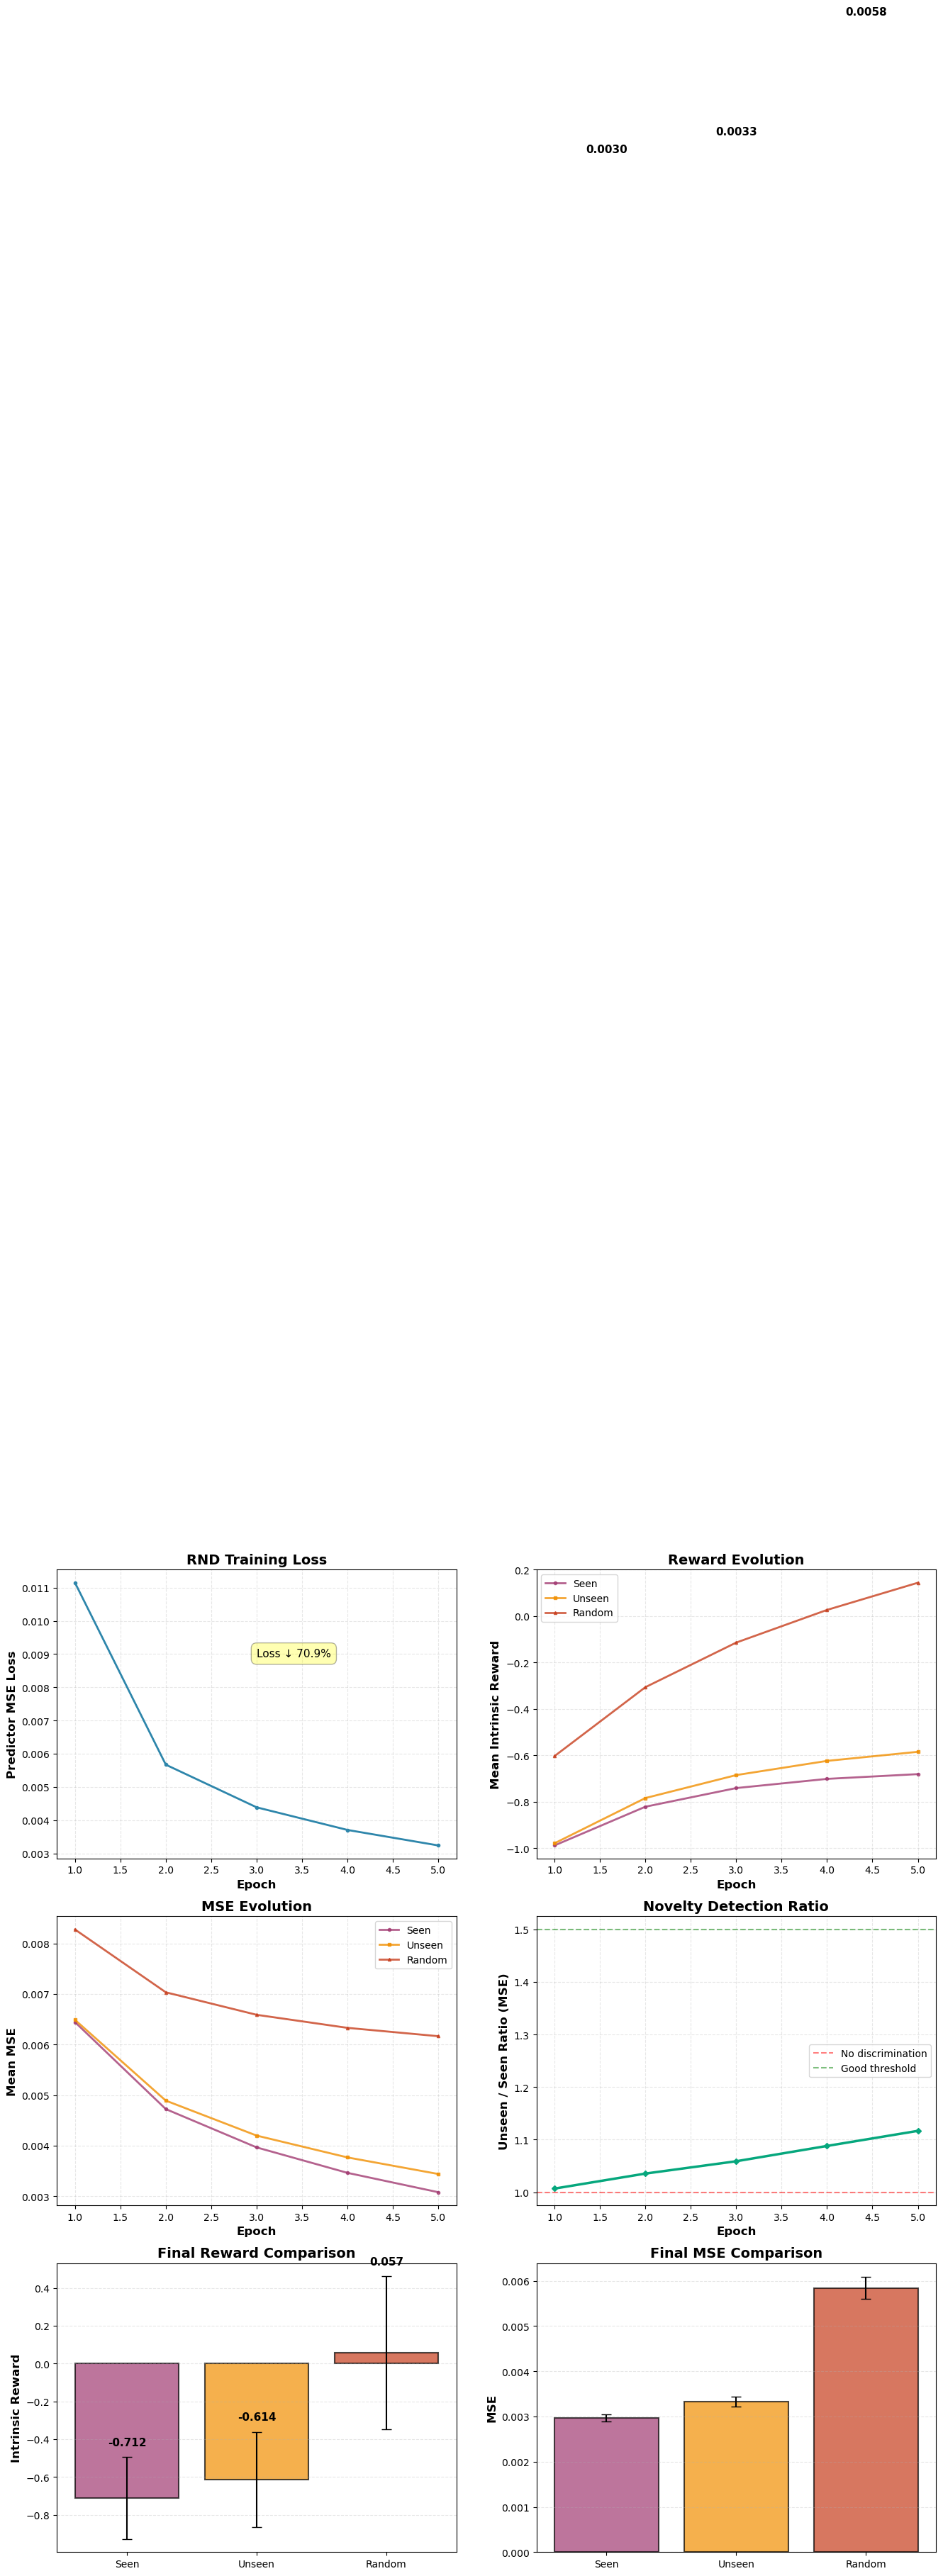

✓ Results saved to 'results/results_gte_train1000_ep5_lr0.0001_bs50_T256_128_64_P512_256_64_norm_noconcat_20251117_235741.json'

Experiment complete.


In [13]:
# Example: Run a single experiment
results = run_rnd_experiment(
    encoder_name='gte',  # Use short name: 'granite', 'granite-small', or 'gte'
    num_train_samples=1000,
    num_epochs=5,
    learning_rate=1e-4,
    batch_size=50,
    target_layers=(256, 128, 64),
    predictor_layers=(512, 256, 64),
    normalize_embeddings=True,
    concat_problem_answer=False,
    save_dir='results'
)

# Hyperparameter Tuning: Run Multiple Experiments

Run multiple experiments with different hyperparameters to find the best configuration:

In [ ]:
import time

# Define hyperparameter configurations to test
experiment_configs = [
    # Baseline with GTE encoder
    {
        'name': 'baseline_gte',
        'encoder_name': 'gte',
        'num_train_samples': 1000,
        'num_epochs': 10,
        'learning_rate': 1e-4,
        'batch_size': 50,
        'target_layers': (256, 64),
        'predictor_layers': (512, 64),
        'normalize_embeddings': True,
        'concat_problem_answer': False,
    },
    
    # Test Granite encoder
    {
        'name': 'granite_encoder',
        'encoder_name': 'granite-small',
        'num_train_samples': 1000,
        'num_epochs': 10,
        'learning_rate': 1e-4,
        'batch_size': 50,
        'target_layers': (256, 64),
        'predictor_layers': (512, 64),
        'normalize_embeddings': True,
        'concat_problem_answer': False,
    },
    
    # # Test Granite Small encoder
    # {
    #     'name': 'granite_small_encoder',
    #     'encoder_name': 'granite-small',
    #     'num_train_samples': 1000,
    #     'num_epochs': 50,
    #     'learning_rate': 1e-4,
    #     'batch_size': 50,
    #     'target_layers': (256, 128, 64),
    #     'predictor_layers': (512, 256, 64),
    #     'normalize_embeddings': True,
    #     'concat_problem_answer': False,
    # },
    
    # # Vary learning rate (with GTE)
    # {
    #     'name': 'high_lr_gte',
    #     'encoder_name': 'gte',
    #     'num_train_samples': 1000,
    #     'num_epochs': 50,
    #     'learning_rate': 5e-4,
    #     'batch_size': 50,
    #     'target_layers': (256, 128, 64),
    #     'predictor_layers': (512, 256, 64),
    #     'normalize_embeddings': True,
    #     'concat_problem_answer': False,
    # },
    # {
    #     'name': 'low_lr_gte',
    #     'encoder_name': 'gte',
    #     'num_train_samples': 1000,
    #     'num_epochs': 50,
    #     'learning_rate': 5e-5,
    #     'batch_size': 50,
    #     'target_layers': (256, 128, 64),
    #     'predictor_layers': (512, 256, 64),
    #     'normalize_embeddings': True,
    #     'concat_problem_answer': False,
    # },
    
    # # Vary network architecture
    # {
    #     'name': 'deeper_networks',
    #     'encoder_name': 'gte',
    #     'num_train_samples': 1000,
    #     'num_epochs': 50,
    #     'learning_rate': 1e-4,
    #     'batch_size': 50,
    #     'target_layers': (512, 256, 128, 64),
    #     'predictor_layers': (512, 256, 128, 64),
    #     'normalize_embeddings': True,
    #     'concat_problem_answer': False,
    # },
    # {
    #     'name': 'wider_networks',
    #     'encoder_name': 'gte',
    #     'num_train_samples': 1000,
    #     'num_epochs': 50,
    #     'learning_rate': 1e-4,
    #     'batch_size': 50,
    #     'target_layers': (512, 512, 64),
    #     'predictor_layers': (768, 512, 64),
    #     'normalize_embeddings': True,
    #     'concat_problem_answer': False,
    # },
    
    # # Test concatenation strategy
    # {
    #     'name': 'with_concat',
    #     'encoder_name': 'gte',
    #     'num_train_samples': 1000,
    #     'num_epochs': 50,
    #     'learning_rate': 1e-4,
    #     'batch_size': 50,
    #     'target_layers': (256, 128, 64),
    #     'predictor_layers': (512, 256, 64),
    #     'normalize_embeddings': True,
    #     'concat_problem_answer': True,
    # },
    
    # # Test without normalization
    # {
    #     'name': 'no_normalization',
    #     'encoder_name': 'gte',
    #     'num_train_samples': 1000,
    #     'num_epochs': 50,
    #     'learning_rate': 1e-4,
    #     'batch_size': 50,
    #     'target_layers': (256, 128, 64),
    #     'predictor_layers': (512, 256, 64),
    #     'normalize_embeddings': False,
    #     'concat_problem_answer': False,
    # },
    
    # # Best encoder with best config
    # {
    #     'name': 'granite_optimized',
    #     'encoder_name': 'granite',
    #     'num_train_samples': 1000,
    #     'num_epochs': 50,
    #     'learning_rate': 5e-4,
    #     'batch_size': 50,
    #     'target_layers': (512, 256, 64),
    #     'predictor_layers': (768, 512, 64),
    #     'normalize_embeddings': True,
    #     'concat_problem_answer': False,
    # },
]

# Run all experiments
all_results = []
summary_path = 'results/all_experiments_summary.json'

# Load existing results if resuming
if Path(summary_path).exists():
    print(f"\n📂 Found existing summary file: {summary_path}")
    with open(summary_path, 'r') as f:
        all_results = json.load(f)
    print(f"✓ Loaded {len(all_results)} previous experiment(s)")
    
    # Extract completed experiment names
    completed_names = {result.get('experiment_name', '') for result in all_results}
    print(f"✓ Completed experiments: {completed_names}")
else:
    print(f"\n📂 Starting fresh - no previous results found")
    completed_names = set()

for i, config in enumerate(experiment_configs):
    exp_name = config.get('name', f'experiment_{i+1}')
    
    # Skip if already completed
    if exp_name in completed_names:
        print(f"\n⏭️  Skipping '{exp_name}' (already completed)")
        continue
    
    print(f"\n{'='*70}")
    print(f"Running Experiment {i+1}/{len(experiment_configs)}: {exp_name}")
    print(f"{'='*70}")
    
    # Record start time
    start_time = time.time()
    start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"🕐 Started at: {start_datetime}\n")
    
    # Extract name and remove from config
    config_copy = config.copy()
    config_copy.pop('name')
    
    try:
        # Run experiment
        results = run_rnd_experiment(**config_copy, save_dir='results')
        
        # Record end time
        end_time = time.time()
        end_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        duration_seconds = end_time - start_time
        duration_minutes = duration_seconds / 60
        
        # Add timing and experiment name to results
        results['experiment_name'] = exp_name
        results['timing'] = {
            'start_time': start_datetime,
            'end_time': end_datetime,
            'duration_seconds': duration_seconds,
            'duration_minutes': duration_minutes,
            'duration_formatted': f"{int(duration_minutes)}m {int(duration_seconds % 60)}s"
        }
        
        all_results.append(results)
        
        # Save incremental summary after each experiment
        with open(summary_path, 'w') as f:
            json.dump(all_results, f, indent=2)
        
        print(f"\n✅ Experiment '{exp_name}' completed successfully!")
        print(f"🕐 Ended at: {end_datetime}")
        print(f"⏱️  Duration: {int(duration_minutes)}m {int(duration_seconds % 60)}s ({duration_seconds:.1f}s)")
        print(f"💾 Summary updated: {summary_path} (now contains {len(all_results)} experiments)")
        
    except Exception as e:
        print(f"\n❌ Experiment '{exp_name}' failed with error: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*70}")
print(f"🎉 All experiments completed!")
print(f"📊 Total experiments run: {len(all_results)}")
print(f"💾 Final summary saved to: {summary_path}")
print(f"{'='*70}")


# Compare Results Across Experiments

Analyze and compare the results from all experiments:

In [ ]:
import pandas as pd

# Create comparison dataframe
comparison_data = []

for result in all_results:
    comparison_data.append({
        'Experiment': result.get('experiment_name', 'unknown'),
        'Encoder': result['hyperparameters']['encoder_name'],
        'Learning Rate': result['hyperparameters']['learning_rate'],
        'Target Layers': str(result['hyperparameters']['target_layers']),
        'Predictor Layers': str(result['hyperparameters']['predictor_layers']),
        'Normalize Emb': result['hyperparameters']['normalize_embeddings'],
        'Concat': result['hyperparameters']['concat_problem_answer'],
        'Final Loss': result['training_metrics']['final_loss'],
        'Loss Reduction %': result['training_metrics']['loss_reduction_pct'],
        'Final Ratio': result['training_metrics']['final_ratio'],
        'Ratio Improvement %': result['training_metrics']['ratio_improvement_pct'],
        'MSE Unseen/Seen': result['test_results']['ratios']['unseen_vs_seen'],
        'Novelty Detection': result['interpretation']['novelty_detection'],
        'Predictor Learned': result['interpretation']['predictor_learned'],
        'Discrimination Improved': result['interpretation']['discrimination_improved'],
    })

df_comparison = pd.DataFrame(comparison_data)

# Display comparison
print("\n" + "="*120)
print("EXPERIMENT COMPARISON")
print("="*120)
print(df_comparison.to_string(index=False))
print("="*120)

# Find best experiment
best_idx = df_comparison['MSE Unseen/Seen'].idxmax()
best_experiment = df_comparison.iloc[best_idx]

print(f"\n🏆 Best Experiment: {best_experiment['Experiment']}")
print(f"   Encoder: {best_experiment['Encoder']} ({get_encoder_name(best_experiment['Encoder'])})")
print(f"   MSE Ratio (Unseen/Seen): {best_experiment['MSE Unseen/Seen']:.3f}x")
print(f"   Final Ratio: {best_experiment['Final Ratio']:.3f}x")
print(f"   Novelty Detection: {best_experiment['Novelty Detection']}")

# Save comparison to CSV
csv_path = 'results/experiment_comparison.csv'
df_comparison.to_csv(csv_path, index=False)
print(f"\n✓ Comparison table saved to: {csv_path}")

# Visualization: Compare key metrics across experiments
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

experiments = df_comparison['Experiment'].tolist()
x_pos = np.arange(len(experiments))

# Color by encoder type
colors_map = {'granite': '#2E86AB', 'granite-small': '#06A77D', 'gte': '#F18F01'}
bar_colors = [colors_map.get(enc, '#A23B72') for enc in df_comparison['Encoder']]

# Plot 1: MSE Ratio
axes[0, 0].bar(x_pos, df_comparison['MSE Unseen/Seen'], color=bar_colors, alpha=0.7)
axes[0, 0].axhline(y=1.5, color='green', linestyle='--', alpha=0.5, label='Good threshold')
axes[0, 0].set_ylabel('MSE Ratio (Unseen/Seen)', fontweight='bold')
axes[0, 0].set_title('Novelty Detection Performance', fontweight='bold', fontsize=14)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(experiments, rotation=45, ha='right', fontsize=9)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Final Loss
axes[0, 1].bar(x_pos, df_comparison['Final Loss'], color=bar_colors, alpha=0.7)
axes[0, 1].set_ylabel('Final Training Loss', fontweight='bold')
axes[0, 1].set_title('Training Convergence', fontweight='bold', fontsize=14)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(experiments, rotation=45, ha='right', fontsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Loss Reduction
axes[1, 0].bar(x_pos, df_comparison['Loss Reduction %'], color=bar_colors, alpha=0.7)
axes[1, 0].set_ylabel('Loss Reduction (%)', fontweight='bold')
axes[1, 0].set_title('Learning Progress', fontweight='bold', fontsize=14)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(experiments, rotation=45, ha='right', fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Final Ratio
axes[1, 1].bar(x_pos, df_comparison['Final Ratio'], color=bar_colors, alpha=0.7)
axes[1, 1].axhline(y=1.5, color='green', linestyle='--', alpha=0.5, label='Good threshold')
axes[1, 1].set_ylabel('Final Epoch Ratio', fontweight='bold')
axes[1, 1].set_title('Discrimination Ratio (MSE)', fontweight='bold', fontsize=14)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(experiments, rotation=45, ha='right', fontsize=9)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add legend for encoder colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', alpha=0.7, label='granite'),
    Patch(facecolor='#06A77D', alpha=0.7, label='granite-small'),
    Patch(facecolor='#F18F01', alpha=0.7, label='gte')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, 
          title='Encoder Type', bbox_to_anchor=(0.5, 0.98), fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
comparison_plot_path = 'results/experiment_comparison.png'
plt.savefig(comparison_plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Comparison plot saved to: {comparison_plot_path}")
plt.show()